# AI vs Human Text Classifier 🧠💬

this project is about building a computer program that can guess if a piece of writing was made by a human or by an AI . It's a "binary classifier" because it just picks one of two options: human or AI.

I used techniques like:
* **Lemmatization:** Making words go back to their basic form (like "running" becomes "run").
* **TF-IDF:** A way to turn words into numbers so the computer can understand them.
* **Different AI "Brains":** tried out a few different machine learning models, like SVM, Decision Tree, and AdaBoost.

Then I checked how well they did using some graphs and numbers like ROC AUC, confusion matrices, and accuracy. At the end, I  save my guesses to a CSV file.

## 1. Setup

importing all the Python libraries I'll be using throughout this project.

I also need to download special language tools from NLTK. These "stopwords"  are words I usually want to ignore because they don't tell me much about *who* wrote something. And "wordnet" helps me with lemmatization later, which is important for cleaning up the text.


In [4]:
# Human_vs_AI_Detection.ipynb
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 1. Setup & Imports

 setting up everything we’ll need for the project. We import libraries like NLTK for text processing, pandas and numpy for working with data, and scikit-learn for building and evaluating our models. We also download some NLTK tools that help with cleaning the text later.


In [5]:

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Load & Preprocess Training Data

 load our Excel file that has the training data for the essays. Then we clean the text by lowercasing it, removing punctuation, getting rid of stop words like “the” or “and,” and lemmatizing words so they’re in their root form. This helps the model understand the content better.


In [6]:

df = pd.read_excel("AI_vs_huam_train_dataset.xlsx")


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["cleaned"] = df["essay"].apply(clean_text)

## 3. Vectorization + Train/Test Split

We use TF-IDF to turn the cleaned text into numbers that the models can actually work with. Then we split the data into training and validation sets, using 80% to train and 20% to test.

## 4. Train Models (SVM, Decision Tree, AdaBoost)

Here we train three different models using GridSearchCV to find the best parameters. We're using SVM, Decision Tree, and AdaBoost to compare performance and pick the one that works best.


In [7]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned"])
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


svm_grid = GridSearchCV(SVC(probability=True), {'C':[0.1, 1], 'kernel':['linear']}, cv=3, scoring='accuracy')
tree_grid = GridSearchCV(DecisionTreeClassifier(), {'max_depth':[5, 10]}, cv=3, scoring='accuracy')
ada_grid = GridSearchCV(AdaBoostClassifier(), {'n_estimators':[50, 100]}, cv=3, scoring='accuracy')

svm_grid.fit(X_train, y_train)
tree_grid.fit(X_train, y_train)
ada_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=AdaBoostClassifier(),
             param_grid={'n_estimators': [50, 100]}, scoring='accuracy')

## 5. Evaluate Models (Confusion Matrix, ROC, Report)

Now we check how each model actually performs. We use classification reports and confusion matrices to see their accuracy and errors, and we also plot the ROC curve to compare how good each model is at separating the two classes.



=== SVM ===
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       373
           1       0.96      0.97      0.97       373

    accuracy                           0.97       746
   macro avg       0.97      0.97      0.97       746
weighted avg       0.97      0.97      0.97       746

Confusion Matrix:
 [[359  14]
 [ 12 361]]

=== Decision Tree ===
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       373
           1       0.86      0.82      0.84       373

    accuracy                           0.84       746
   macro avg       0.84      0.84      0.84       746
weighted avg       0.84      0.84      0.84       746

Confusion Matrix:
 [[322  51]
 [ 69 304]]

=== AdaBoost ===
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       373
           1       0.95      0.95      0.95       373

    accuracy                           0.95 

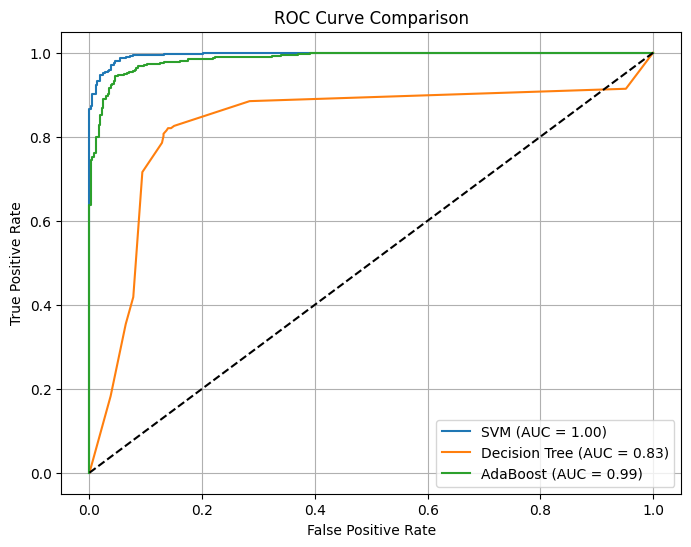

In [8]:

models = {
    "SVM": svm_grid,
    "Decision Tree": tree_grid,
    "AdaBoost": ada_grid
}

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_pred = model.predict(X_val)
    y_prob = model.predict_proba(X_val)[:,1]
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    print(f"\n=== {name} ===")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load & Clean the Final Test Data

Now we’re loading in the final test CSV file so we can run our trained models on it later. We also clean the text the same way we cleaned the training data—removing punctuation, lowering the case, removing stopwords, and lemmatizing the words.


In [10]:


import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


final_df = pd.read_csv("Final_test_data.csv")


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)


final_df["cleaned"] = final_df["essay"].apply(clean_text)

## Make Predictions on the Final Test Set

We’re using the same TF-IDF vectorizer from earlier to transform the new cleaned test data. Then, we take our best model (SVM in this case) and use it to predict whether each essay was written by a human or AI.


In [11]:

X_test_final = vectorizer.transform(final_df["cleaned"])


final_predictions = svm_grid.best_estimator_.predict(X_test_final)

## Export Predictions as CSV

This saves the final predictions into a CSV file so we can download it. We add an `id` column just for formatting and include both `id` and `label` columns in the output.


In [12]:

final_df["label"] = final_predictions
final_df["id"] = range(len(final_df))

output = final_df[["id", "label"]]
output.to_csv("Final_predictions.csv", index=False)

#  download
from google.colab import files
files.download("Final_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import joblib

joblib.dump(vectorizer, "vectorizer.joblib")
joblib.dump(svm_grid.best_estimator_, "svm_model.joblib")
joblib.dump(tree_grid.best_estimator_, "tree_model.joblib")
joblib.dump(ada_grid.best_estimator_, "ada_model.joblib")



['ada_model.joblib']